## Información y Programación Financiera, TI, Algoritmos y Ciencia de Datos

# Backtesting

Neftalí Valdez

<a href="http://twitter.com/neftalivldz" target="_blank">@neftalivldz</a> | <a href="mailto:nvaldez@tec.mx">nvaldez@tec.mx</a>

In [1]:
#%pip install pandas_ta


In [1]:
import refinitiv.dataplatform as rdp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from IPython.display import clear_output
import asyncio
import pandas_ta as ta

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
%run ../credentials.ipynb

In [4]:
session = rdp.open_platform_session(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)

Retreive Time Series data from RDP

After the session state is Open, we will use the below get_historical_price_summaries interface to retrieve time series pricing Interday summaries data(i.e., bar data).

get_historical_price_summaries(universe, interval=None, start=None, end=None, adjustments=None, sessions=[], count=1, fields=[], on_response=None, closure=None)
Actually, the implementation of this function will send HTTP GET requests to the following RDP endpoint.

https://api.refinitiv.com/data/historical-pricing/v1/views/interday-summaries/
And the following details are possible values for interval and adjustment arguments.

Supported intervals: Intervals.DAILY, Intervals.WEEKLY, Intervals.MONTHLY, Intervals.QUARTERLY, Intervals.YEARLY.

Supported value for adjustments: 'unadjusted', 'exchangeCorrection', 'manualCorrection', 'CCH', 'CRE', 'RPO', 'RTS', 'qualifiers'

You can pass an array of these values to the function like the below sample codes.

adjustments=['unadjusted']
adjustments=['unadjusted','CCH','CRE','RPO','RTS']
Please find below details regarding the adjustments behavior; it's the details from a reference section on the APIDocs page. Note that it can be changed in future releases. I would suggest you leave it to the default value.

The adjustments are a query parameter that tells the system whether to apply or not apply CORAX (Corporate Actions) events or exchange/manual corrections or price and volume adjustment according to trade/quote qualifier summarization actions to historical time series data.

Normally, the back-end should strictly serve what clients need. However, if the back-end cannot support them, the back-end can still return the form that the back-end supports with the proper adjustments in the response and status block (if applicable) instead of an error message.

Limitations: Adjustment behaviors listed in the limitation section may be changed or improved in the future.

If any combination of correction types is specified (i.e., exchangeCorrection or manualCorrection), all correction types will be applied to data in applicable event types.

If any combination of CORAX is specified (i.e., CCH, CRE, RPO, and RTS), all CORAX will be applied to data in applicable event types.

Adjustments values for Interday-summaries and Intraday-summaries API

If unspecified, each back-end service will be controlled with the proper adjustments in the response so that the clients know which adjustment types are applied by default. In this case, the returned data will be applied with exchange and manual corrections and applied with CORAX adjustments.

If specified, the clients want to get some specific adjustment types applied or even unadjusted.

The supported values of adjustments:

exchangeCorrection - Apply exchange correction adjustment to historical pricing
manualCorrection - Apply manual correction adjustment to historical pricing, i.e., annotations made by content analysts
CCH - Apply Capital Change adjustment to historical Pricing due to Corporate Actions, e.g., stock split
CRE - Apply Currency Redenomination adjustment when there is redenomination of the currency
RTS - Apply Reuters TimeSeries adjustment to adjust both historical price and volume
RPO - Apply Reuters Price Only adjustment to adjust historical price only, not volume
unadjusted - Not apply both exchange/manual correct and CORAX
Notes:

Summaries data will always have exchangeCorrection and manualCorrection applied. If the request is explicitly asked for uncorrected data, a status block will be returned along with the corrected data saying, "Uncorrected summaries are currently not supported".

unadjusted will be ignored when other values are specified.

Source: Forecast Stock Price using RDP Historical Pricing with Facebook Prophet library
https://github.com/LSEG-API-Samples/Article.RDPAPI.Python.PriceForcastUsingFBProPhet/blob/main/rdp_fbprophet.ipynb

## Get a time series

In [5]:
ricName='AAPL.O'
StartDate='2020.01.01'
EndDate=str(datetime.date.today())

data=rdp.get_historical_price_summaries(
        universe=ricName,
        interval=rdp.Intervals.DAILY, # Supported intervals: DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY.
        start=StartDate, end=EndDate
        #, fields = ['BID','ASK']
)


In [6]:
#help(ta)

In [7]:
data.index.name="Date"
df=data
#.reset_index(level=0)
#df['Date'] = df['Date'].values.astype('datetime64[ns]')

# VWAP requires the DataFrame index to be a DatetimeIndex.
# Replace "datetime" with the appropriate column from your DataFrame
#df.set_index(pd.DatetimeIndex(df["Date"]), inplace=True)

# Select only the important features i.e. the date and price
df = df[["TRDPRC_1"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
df = df.rename(columns = {"TRDPRC_1":"close"}) #renaming the columns of the dataset
display(df.head())

,close
Date,
2020-01-02,75.0875
2020-01-03,74.3575
2020-01-06,74.95
2020-01-07,74.5975
2020-01-08,75.7975


In [8]:
df.dtypes

close    Float64
dtype: object

In [9]:
for t in [5, 21, 63]:
    df[f'SMA_{t}'] = ta.sma(df['close'],
                               length=t)

In [10]:
df[0:50]

,close,SMA_5,SMA_21,SMA_63
Date,,,,
2020-01-02,75.0875,NaN,NaN,NaN
2020-01-03,74.3575,NaN,NaN,NaN
2020-01-06,74.95,NaN,NaN,NaN
2020-01-07,74.5975,NaN,NaN,NaN
2020-01-08,75.7975,74.9580,NaN,NaN
2020-01-09,77.4075,75.4220,NaN,NaN
2020-01-10,77.5825,76.0670,NaN,NaN
2020-01-13,79.24,76.9250,NaN,NaN
2020-01-14,78.17,77.6395,NaN,NaN


In [35]:
plt.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'svg'

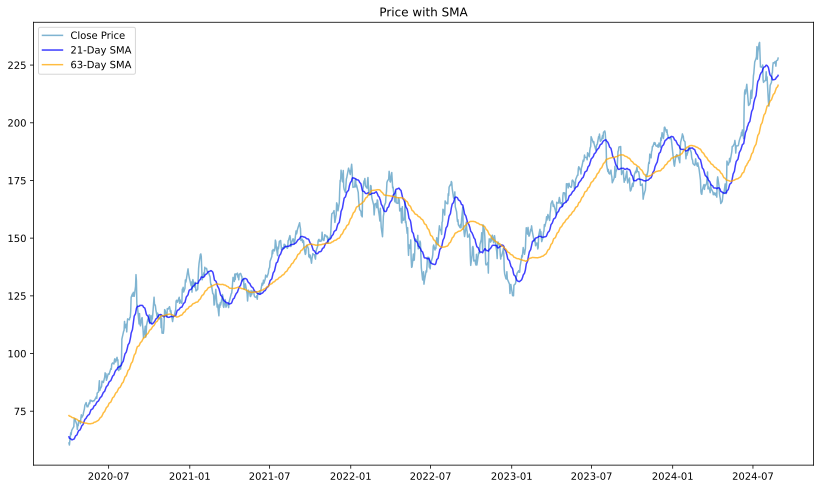

In [36]:
# Plotting
plt.figure(figsize=(14, 8))

# Plot Closing Price and SMAs
plt.plot(df['close'], label='Close Price', alpha=0.5)
plt.plot(df['SMA_21'], label='21-Day SMA', alpha=0.75, color='blue')
plt.plot(df['SMA_63'], label='63-Day SMA', alpha=0.75, color='orange')

plt.title('Price with SMA')
plt.legend()
plt.show()

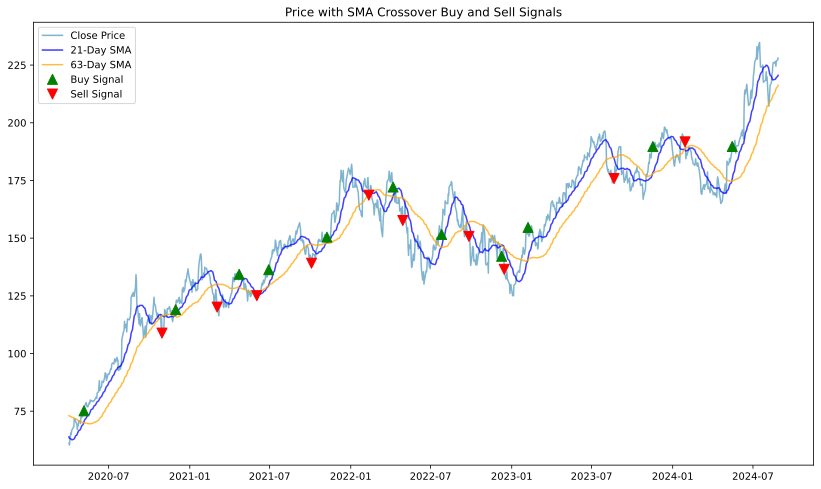

In [37]:
# Generate Buy and Sell signals
df['Buy_Signal'] = np.where((df['SMA_21'] > df['SMA_63']) & (df['SMA_21'].shift(1) <= df['SMA_63'].shift(1)), 1, 0)
df['Sell_Signal'] = np.where((df['SMA_21'] < df['SMA_63']) & (df['SMA_21'].shift(1) >= df['SMA_63'].shift(1)), -1, 0)

# Plotting
plt.figure(figsize=(14, 8))

# Plot Closing Price and SMAs
plt.plot(df['close'], label='Close Price', alpha=0.5)
plt.plot(df['SMA_21'], label='21-Day SMA', alpha=0.75, color='blue')
plt.plot(df['SMA_63'], label='63-Day SMA', alpha=0.75, color='orange')

# Plot Buy Signals
plt.plot(df[df['Buy_Signal'] == 1].index, df['close'][df['Buy_Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot Sell Signals
plt.plot(df[df['Sell_Signal'] == -1].index, df['close'][df['Sell_Signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Price with SMA Crossover Buy and Sell Signals')
plt.legend()
plt.show()


In [38]:
df['position'] = np.where((df['SMA_21'] > df['SMA_63']),  
                             1,  
                             -1) 

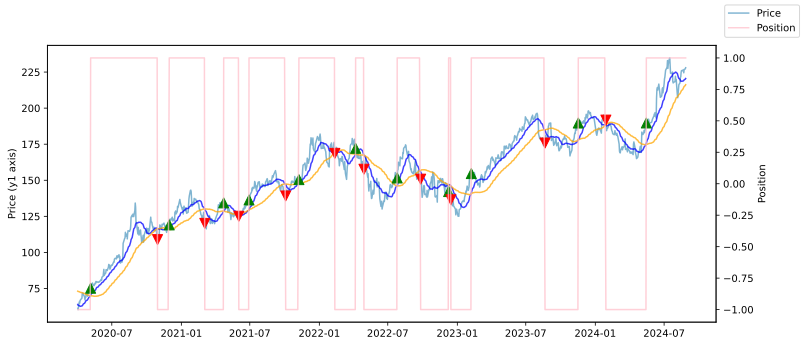

In [39]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator


fig,ax1 = plt.subplots(figsize=(12,5))
l1, = ax1.plot(df.index, df['close'], label='Close Price', alpha=0.5) #Your Price field
ax1.set_ylabel('Price (y1 axis)')
ax1.plot(df['SMA_21'], label='21-Day SMA', alpha=0.75, color='blue')
ax1.plot(df['SMA_63'], label='63-Day SMA', alpha=0.75, color='orange')
ax1.plot(df[df['Buy_Signal'] == 1].index, df['close'][df['Buy_Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
ax1.plot(df[df['Sell_Signal'] == -1].index, df['close'][df['Sell_Signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')


ax2 = ax1.twinx() ##Using twinx to make ax2 as secondary axis for ax1
l2, = ax2.plot(df.index,df['position'], alpha=0.75, color='pink') #Your sales field
ax2.set_ylabel('Position')

fig.legend([l1, l2], ["Price", "Position"])

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)

In [40]:
df['Returns'] = np.log(df['close'] / df['close'].shift(1))
df['Strategy'] = df['position'].shift(1) * df['Returns']  
df.round(4).head()


,close,SMA_5,SMA_21,SMA_63,Buy_Signal,Sell_Signal,position,Returns,Strategy
Date,,,,,,,,,
2020-04-02,61.2325,62.1340,63.9136,73.1097,0,0,-1,<NA>,<NA>
2020-04-03,60.3525,61.8175,63.3004,72.8874,0,0,-1,-0.0145,0.0145
2020-04-06,65.6175,62.2005,62.9842,72.7392,0,0,-1,0.0836,-0.0836
2020-04-07,64.8575,62.4575,62.9039,72.5846,0,0,-1,-0.0116,0.0116
2020-04-08,66.5175,63.7155,62.6745,72.4373,0,0,-1,0.0253,-0.0253


In [41]:
df.dropna(inplace=True)


In [42]:
np.exp(df[['Returns', 'Strategy']].sum())  

Returns     3.724003
Strategy    0.949835
dtype: Float64

In [43]:
df[['Returns', 'Strategy']].std() * 252 ** 0.5

Returns     0.292787
Strategy    0.293393
dtype: Float64

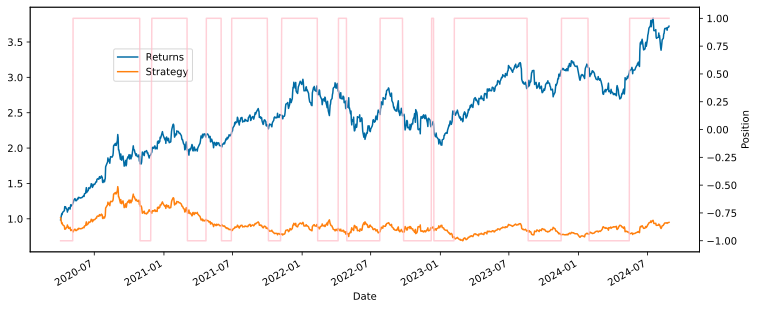

In [44]:

ax1 = df[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(12,5))

ax2 = ax1.twinx() ##Using twinx to make ax2 as secondary axis for ax1
l2, = ax2.plot(df.index,df['position'], alpha=0.75, color='pink') #Your sales field
ax2.set_ylabel('Position')

fig.legend([l1, l2], ["Price", "Position"])

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)

ax1.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_03.png');

Bibliography

Vahid. Using Pandas_TA To Generate Technical Indicators And Signals
https://pythonology.eu/using-pandas_ta-to-generate-technical-indicators-and-signals/

Stefan Jansen. Machine learning for trading
https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/24_alpha_factor_library/02_common_alpha_factors.ipynb

Ives Hilpisch. Python for Finance
https://github.com/yhilpisch/py4fi2nd/blob/master/code/ch15/15_trading_strategies_a.ipynb

Forecast Stock Price using RDP Historical Pricing with Facebook Prophet library https://github.com/LSEG-API-Samples/Article.RDPAPI.Python.PriceForcastUsingFBProPhet/blob/main/rdp_fbprophet.ipynb